# N-grams as Tokens for Phrases

In this first project work we will use N-grams as tokens to create phrases in English and evaluate how much sense these phrases make.

### Data preparation

One of the most important parts of this project is preparing N-grams so that they can be used as tokens later on. There are two approaches:
- using an existing dictionary of N-grams, such as Google Ngram;
- creating a new one from a large corpus of text.
We will be using the second approach since it would be easier to train our model on the topics we are interested in.

Another choice that has to be made is how many items do we want to consider for the N-grams? We will create a dictionary of **3 words** using NLTK library corpora. The main disadvantage of NLTK is that its corpora is quite limited in size and in application. But they are already cleaned and tokenized. This saves time on preprocessing.

In [1]:
pip install numpy==1.19.5 matplotlib==3.3.4 --user

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.3 in c:\users\mo4al\anaconda3\lib\site-packages (from matplotlib==3.3.4) (3.0.4)



In [2]:
pip install transformers torch sentencepiece torcheval happytransformer evaluate rouge-score

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
from collections import defaultdict, Counter
from nltk.util import ngrams
import nltk
from nltk.corpus import brown, gutenberg, reuters, inaugural, movie_reviews
import pickle

In [4]:
# punkt is a Sentence Tokenizer
nltk.download('punkt')
# Gutenberg Corpus includes public domain literary texts from authors like Shakespeare and Jane Austen
nltk.download('gutenberg')

# more corpora that can be used to create the dictionary
nltk.download('brown')
nltk.download('reuters')
nltk.download('inaugural')
nltk.download('movie_reviews')

# loading the corpus
all_words = gutenberg.words()
    
# generating bigrams (n=2) or trigrams (n=3)
n = 3
trigrams = list(ngrams(all_words, n))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mo4al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\mo4al\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\mo4al\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\mo4al\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package inaugural to
[nltk_data]     C:\Users\mo4al\AppData\Roaming\nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\mo4al\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


If we want to work on a large-scale NLP project that requires substantial data, we might want to switch to a larger corpus like Common Crawl (hundreds of TB, but need to preprocess and clean), OpenWebText (about 40GB), or Wikipedia Dump (about 25GB).
We would need to:
- download the corpus;
- preprocess removing tags, non article sections (if using Wikipedia);
- tokenize sentences into words

A different code should be executed if we want to use an available N-gram dataset, for example Google Ngram Viewer.
https://storage.googleapis.com/books/ngrams/books/datasetsv3.html

### Building the model
We want to create an N-gram language model using the data prepared in the first step. It is also possible to build a frequency-based model, where the likelihood of an n-gram appearing is proportional to its frequency in the training data.


In [5]:
def create_trigram_model(trigrams):
    # getting the frequency of each n-gram
    ngram_freq = Counter(trigrams)

    # creating a dictionary where each (n-1)-gram maps to possible next words
    model = defaultdict(list)

    # for trigrams, the prefix will be the first two words, and the next word will be the third
    for (w1, w2, w3) in trigrams:
        model[(w1, w2)].append(w3)

    return ngram_freq, model

### Generating phrases
We consider an initial word from which our phrase would start (in the dictionary it would be preceeded by special tokens to indicate their probable position at the beginning of the phrase), then we predict the next word by sampling from the probability distribution of possible next words given the previous n-1 words. We should continue this process until a phrase is of a certain length or a stop condition is met.
The choice of the next word can be done using one of these approaches:
- **greedy**: always pick the most probable word;
- **random**: sample words based on probability in the corpus.

To create phrases that flow better, we added some conditions, such as no repeating words, since it is something that very rarely happens in natural language. There is also a checker to see if the next generated word would be punctuation, in that case the word generation stops.

In [6]:
def generate_random_text(model, start_words, length=50):
    text = list(start_words)
    current_words = tuple(start_words)
    
    for _ in range(length):
        if current_words in model:
            
            # Choose the next word based on its frequency distribution
            next_word = random.choice(model[current_words])
            while len(text) > 0 and next_word == text[-1]:
                next_word = random.choice(model[current_words])

            # Check if the next word is punctuation, then break before appending
            if next_word in {".", "!", "?"}:
                text.append(next_word)
                break
            text.append(next_word)
            current_words = tuple(text[-(len(start_words)):])
        else:
            break  # Stop if we no next word is available
    
    return ' '.join(text)

def generate_greedy_text(model, start_words, length=50):
    text = list(start_words)
    current_words = tuple(start_words)
    
    for _ in range(length):
        if current_words in model:
            
            # Select the most frequent next word
            next_word = Counter(model[current_words]).most_common(1)[0][0]  # Get the most common next word
            if next_word in {".", "!", "?"}:
                text.append(next_word)
                break
            while len(text) > 0 and next_word == text[-1]:
                next_word = random.choice(model[current_words])
            text.append(next_word)
            current_words = tuple(text[-(len(start_words)):])
        else:
            break  # Stop if no next word is available
    
    return ' '.join(text)

In [ ]:
trigram_freq, model_ngram = create_trigram_model(trigrams)

with open('trigram_model.pkl', 'wb') as f:
    pickle.dump((trigram_freq, model_ngram), f)

print("Model saved successfully!")

In [7]:
with open('trigram_model.pkl', 'rb') as f:
    trigram_freq, model_ngram = pickle.load(f)

print("Model loaded successfully!")

Model loaded successfully!


In [8]:
start_words = ('In', 'the')
generated_random_text = generate_random_text(model_ngram, start_words)
print(generated_random_text)

#generated_greedy_text = generate_greedy_text(model_ngram, start_words, length=10)
#print(generated_greedy_text)

In the few really stiff old Tory aristocrats left , and sorroweth for you ' ve no business to fly round and walked , and of one side was a man at all ," said he , whom thou now hast is not all her own , but the devil ' s


### Evaluating phrases
After generating a phrase we pass it to a LLM to evaluate its coherence and fluency, the result can be taken as is or can be used to further increase the model's performance. Some of the metrics to evaluate the phrases can be:
- **perplexity** - calculate the perplexity, the lower the perplexity the better;
- **semantic coherence** - use the LLM to assign a coherence score based on how logical or meaningful the phrase is;
- **classifying phrases as coherent or not** - fine-tune a classification head on the LLM to check whether phrases make sense.


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import sentencepiece as spm
from torcheval.metrics.text import Perplexity

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

Using **HappyTextToText** to check and correct the phrase's grammar produced by the N-gram model.

In [10]:
from happytransformer import HappyTextToText, TTSettings
happy_tt = HappyTextToText("T5", "vennify/t5-base-grammar-correction")

11/04/2024 10:02:44 - INFO - happytransformer.happy_transformer -   Using device: cpu


In [11]:
def correct_grammar(input_phrase):
    args = TTSettings(num_beams=5, min_length=1,  max_length=50)

    formatted_input = f"grammar: {input_phrase}"
    result = happy_tt.generate_text(formatted_input, args=args)
    
    return result.text

print(generated_random_text)
corrected_result = correct_grammar(generated_random_text)
print(corrected_result)

11/04/2024 10:02:45 - INFO - happytransformer.happy_transformer -   Moving model to cpu
11/04/2024 10:02:45 - INFO - happytransformer.happy_transformer -   Initializing a pipeline


In the few really stiff old Tory aristocrats left , and sorroweth for you ' ve no business to fly round and walked , and of one side was a man at all ," said he , whom thou now hast is not all her own , but the devil ' s
In the few really stiff old Tory aristocrats left , and sorroweth for you ' ve no business to fly round and walk , and of one side was a man at all ," said


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(torch_device)

In [ ]:
def compute_phrase_likelihood(phrase):
    input_ids = tokenizer(phrase, return_tensors="pt").input_ids
    
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    
    return -loss.item()

likelihood_score_initial = compute_phrase_likelihood(generated_random_text)
print("Initial Phrase:", generated_random_text)
print("Likelihood Score at the start:", likelihood_score_initial)

likelihood_score_corrected = compute_phrase_likelihood(corrected_result)
print("Corrected Phrase:", corrected_result)
print("Likelihood Score:", likelihood_score_corrected)

Other metrics to evaluate phrases can be:
- BLEU (Bilingual Evaluation Understudy) calculates the precision of N-grams generated by our custom model comparing them to some reference. It is then modified by a brevity penalty to account for phrases that are shorter than the reference ones. The formula is **BLEU = BP * exp(∑ pn)**. This metric is usually used for translation tasks 
- ROUGE (Recall-Oriented Understudy for Gisting Evaluation) measures the similarity between the machine-generated phrases and the reference ones using overlapping n-grams, word sequences that appear in both. The formula is **ROUGE = ∑ (Recall of n-grams)**. This metric usually is used for summary tasks.

Both of them need the same number of sentences in references and predictions, so we compare the sentence produced by our N-gram model and the one produced by HappyTextToText to see how close they were.

In [12]:
import evaluate

predictions = [generated_random_text]
references = [[corrected_result]]

bleu = evaluate.load("bleu")
results_bleu = bleu.compute(predictions=predictions, references=references)

rouge = evaluate.load('rouge')
results_rouge = rouge.compute(predictions=predictions, references=references)

This next part is used to test how well does the model perform in regards to the metrics implemented. It is also interesting to see how long the produced phrases are.

In [13]:
import matplotlib.pyplot as plt

In [14]:
to_print = False
# testing length of generated phrases and BLEU and ROUGE values
X = 100
lengths_of_phrases = []
bleu_scores = []
rougeL_scores = []

for _ in range(X):
    # to generate at random the starting two words of the given dictionary
    index = random.randint(0, len(all_words) - 2)
    start_words = (all_words[index], all_words[index + 1])

    generated_random_text = generate_random_text(model_ngram, start_words)
    lengths_of_phrases.append(len(generated_random_text.split()))
    if to_print:
        print(generated_random_text)

    corrected_result = correct_grammar(generated_random_text)
    if to_print:
        print(corrected_result)

    predictions = [generated_random_text]
    references = [[corrected_result]]

    results_bleu = bleu.compute(predictions=predictions, references=references)
    bleu_score = results_bleu['bleu']
    bleu_scores.append(bleu_score)
    if to_print:
        print("BLEU Score:", bleu_score)
        
    results_rouge = rouge.compute(predictions=predictions, references=references)
    rougeL_score = results_rouge['rougeL']
    rougeL_scores.append(rougeL_score)
    if to_print:
        print("ROUGE-L Score:", rougeL_score)
    # to check for abnormalities
    if bleu_score < 0.3:
        print(generated_random_text)
        print(corrected_result)

his trowsers ' pockets .
His trowsers' pockets.
cause to speake with me ?
Cause to speak with me?
simple dodge .
Simple dodge.
yourselves against me .
You are against me.
, or D ' ye do well : And court the fair girl ' s silver penny .
And court the fair girl's silver penny.
began this Heaven itself into Squid .
This Heaven itself began into Squid.
gods of silver .
Gods of silver.
be so .
Be so.


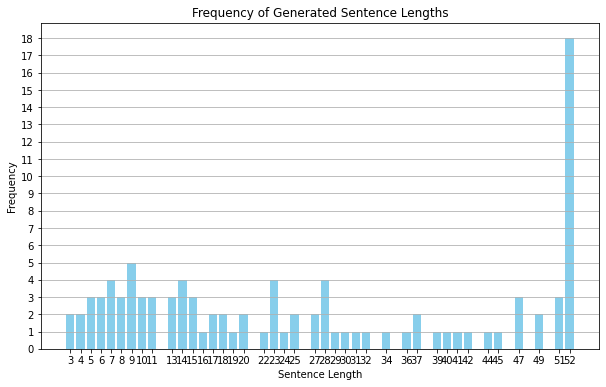

In [15]:
# plotting the generated phrase length

length_counts = Counter(lengths_of_phrases)

plt.figure(figsize=(10, 6))
plt.bar(length_counts.keys(), length_counts.values(), color='skyblue')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Frequency of Generated Sentence Lengths')
plt.xticks(list(length_counts.keys()))
plt.grid(axis='y')
plt.yticks(range(0, max(length_counts.values()) + 1))

plt.savefig('lengths.png', format='png', dpi=300)
plt.show()

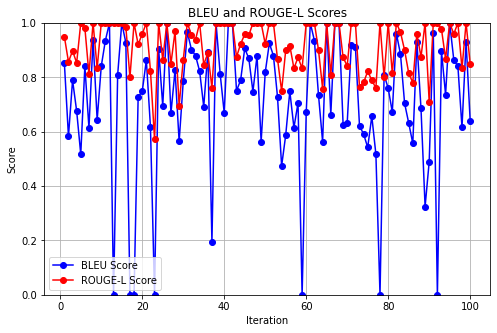

In [17]:
# plotting BLEU and ROUGE

plt.figure(figsize=(8, 5))
plt.plot(range(1, X + 1), bleu_scores, marker='o', label='BLEU Score', color='blue')
plt.plot(range(1, X + 1), rougeL_scores, marker='o', label='ROUGE-L Score', color='red')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('BLEU and ROUGE-L Scores')
plt.ylim(0, 1)  # Scores are between 0 and 1
plt.grid()
plt.legend()

plt.savefig('scores.png', format='png', dpi=300)
plt.show()